In [1]:
%pylab inline
from joblib import Parallel, delayed

import infostop
import pandas as pd
import numpy as np


Populating the interactive namespace from numpy and matplotlib


# load data

In [2]:
df_0 = pd.read_csv('../intermidiate_data/pre_processed_data.csv', parse_dates = [0])[['med_lat','med_lon','timestamp','individual-local-identifier','individual-taxon-canonical-name']]
origin = datetime.datetime(1970,1,1)
df_0['timestamp'] = df_0['timestamp'].apply(lambda x: (x - origin).total_seconds()).astype(int)
df_0 = df_0.rename(columns = {'med_lat':'lat','med_lon':'lon','individual-local-identifier':'user','individual-taxon-canonical-name':'species'})
df_0 = df_0.dropna()
species = df_0.groupby('user')['species'].first().to_dict()
df_0 = df_0.sort_values(by = ['user','timestamp']).reset_index(drop = True)


In [3]:
df_0 = pd.concat([df_0,df_0])
df_0['diff_from_previous'] = df_0['timestamp'] - df_0['timestamp'].shift()
df_0.loc[df_0.diff_from_previous<=0,'diff_from_previous'] = 4*60
df_0['timestamp_new'] = df_0['diff_from_previous'].cumsum()
df_0['user'] = 'same_user'
df_0['timestamp_new'] = df_0['timestamp_new'].fillna(0)

# test new branch infostop

In [4]:
THRESHOLD_DISTANCE = 10
THRESHOLD_DBSCAN = 15
LEN_STOPS = 11*60
THRESHOLD_TIME_MAX = 60*60*2

In [5]:
location_data = df_0[['lat','lon','timestamp_new']].values
print(len(location_data))

1329676


In [6]:

def compute_output(location_data, N_points):

    #Sample of the data
    test_data = location_data[:N_points]
    
    #Time the ball tree
    t0 = time.time()
    result_ball_tree = infostop.label_trace(test_data,
                          r1 = THRESHOLD_DISTANCE, 
                          r2 = THRESHOLD_DBSCAN, 
                          return_intervals=True,
                          min_staying_time=LEN_STOPS,
                          max_time_between=THRESHOLD_TIME_MAX,
                          method = 'ball_tree',
                          label_singleton = True)
    t1 = time.time()
    
    try:
        #Time the distance matrix  (it may not work if matrix is too big, this is why I try)
        result_distance_matrix = infostop.label_trace(test_data,
                          r1 = THRESHOLD_DISTANCE, 
                          r2 = THRESHOLD_DBSCAN, 
                          return_intervals=True,
                          min_staying_time=LEN_STOPS,
                          max_time_between=THRESHOLD_TIME_MAX,
                          method = 'distance_matrix',
                          label_singleton = True)
        t2 = time.time()
        time_2 = (t2-t1)
        
        #Check if the outputs of the two are the same
        correct = all(np.nan_to_num(result_ball_tree)==np.nan_to_num(result_distance_matrix))
        
        
    except:
        time_2 = np.nan
        correct = np.nan
        
    time_1 = (t1-t0)    
    stop_events = len(result_ball_tree)
    return time_1,time_2, stop_events, N_points, correct

In [7]:
numbers_of_points = [int(i) for i in np.logspace(2, np.log10(len(location_data)))]

In [8]:
test = Parallel(n_jobs=10)(delayed(compute_output)(location_data, i) for i in numbers_of_points)

In [9]:
time_1,time_2, stop_events, N_points, correct = zip(*test)

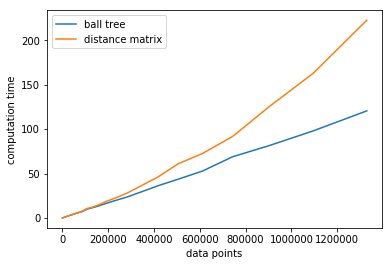

In [10]:
plt.figure()
plt.plot(N_points, time_1, label ='ball tree')
plt.plot(N_points, time_2, label = 'distance matrix')
plt.legend()
plt.xlabel('data points')
plt.ylabel('computation time')
plt.show()

In [11]:
#Fraction of the outputs where the result is the same using the two methods
sum(correct)/len(correct)

1.0